# Importing Libraries

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from pyspark.sql  import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf() \
          .setMaster('local[*]') \
          .setAppName('SB Analytics') \
          .set('spark.driver.memory', '20g') \
          .set('spark.driver.maxResultSizeSets', '8g')
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [ ]:
from pyspark.sql.functions import expr, col, count, sum as sum_, max as max_, min as min_, avg as avg_, round as round_,\
                                  lower, when, udf, mean as mean_, stddev as stddev_, array, struct, product, \
                                  first, last, lit, split, isnan, months_between, row_number, coalesce, size, exp, \
                                  explode, array_repeat, date_format, date_trunc, to_date, to_timestamp, broadcast
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

# Upload Dataset

In [ ]:
dfPatients = spark.read.load('/content/drive/MyDrive/db/patients')
dfObservations = spark.read.load('/content/drive/MyDrive/db/observations')
dfConditions = spark.read.load('/content/drive/MyDrive/db/conditions')
#dfMedications = spark.read.load('/content/drive/MyDrive/db/medications')
dfQuestionnaireResponses = spark.read.load('/content/drive/MyDrive/db/questionnaire_responses')

dfPatients = dfPatients.withColumnRenamed('id','Patient_id')
dfObservations = dfObservations.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))
dfConditions = dfConditions.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))
dfQuestionnaireResponses = dfQuestionnaireResponses.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))

# Functions

## Df related

In [ ]:
'''
Get most recent data
Observations Dataframe related
'''
def codeExtraction(df, code:str, new_name, whichCode = 'code_coding_code', whichValue='component_valueQuantity_value'):
  tmp = df.filter(df[whichCode] == code)
  tmp = tmp.select('effectiveDateTime', 'Patient_id', whichValue)
  tmp_notNull = tmp.filter(tmp.effectiveDateTime.isNotNull()) # & (tmp[whichValue].isNotNull()
  tmp_notNull = tmp_notNull.orderBy(tmp_notNull['effectiveDateTime'].desc())
  recentData = tmp_notNull.groupBy('Patient_id').agg(first(whichValue).alias(new_name))
  # print("Recent data for '" + whichCode + "'")
  # recentData.show()
  return recentData
#codeExtraction(dfObservations, '365458002', whichValue='valueCodeableConcept_coding_display', new_name='nuovo_nome').show(truncate=False)

'''
Get all data corresponding to a given code
Observations Dataframe related
'''
def codeExtractionWithTime(df, code:str, new_name, whichCode = 'code_coding_code', whichValue='component_valueQuantity_value'):
  tmp = df.filter(df[whichCode] == code)
  tmp = tmp.select('effectiveDateTime', 'Patient_id', whichValue)
  tmp_notNull = tmp.filter(tmp.effectiveDateTime.isNotNull()) # & (tmp[whichValue].isNotNull()
  tmp_notNull = tmp_notNull.orderBy(tmp_notNull['effectiveDateTime'].desc())
  return tmp_notNull.withColumnRenamed(whichValue, new_name).distinct()
#codeExtraction(dfObservations, '365458002', whichValue='valueCodeableConcept_coding_display', new_name='nuovo_nome').show(truncate=False)

## Fill dates

In [ ]:
'''
  generates missing dates for each patient, based on patient's min_date and max_date
'''
def generatePersonalizedMissingDates(df):
  #date_trunc --> truncate a date, e.g. with 'mm' parameters: 15/12/2021 --> 01/12/2021
  all_dates_df = df.groupBy("Patient_id").agg(
      max_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("max_date"),
      min_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("min_date")
  ).select(
      "Patient_id",
      expr("sequence(min_date, max_date, interval 1 day)").alias("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime", explode("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime",
      date_format("effectiveDateTime", "yyyy-MM-dd")
  )
  return all_dates_df.join(df, ['Patient_id', 'effectiveDateTime'], 'left')

'''
  fill null values in a column, using values of the same date, if there is not, it's replaced with the mean of the patient's values.
'''
def fillNullByDate(df, cols):
    # uncomment if using more values for a timestamp
    #means = df.groupBy(['Patient_id', 'effectiveDateTime']).agg(*(
    #    mean_(x).alias(x+'_mean_tmp') for x in df.columns if x in cols
    #))
    meanByPatient = df.groupBy(['Patient_id']).agg(*(
        mean_(x).alias(x+'_mean_tmp') for x in df.columns if x in cols
    ))

    #df = df.join(means, on=['effectiveDateTime', 'Patient_id'], how='left_outer')
    #for c in cols:
    #  df = df.withColumn(c, when(col(c).isNotNull(), col(c)).otherwise(col(c+'_mean_tmp'))).drop(c+'_mean_tmp')

    df = df.join(meanByPatient, on=['Patient_id'], how='left_outer')
    for c in cols:
      df = df.withColumn(c, when(col(c).isNotNull(), col(c)).otherwise(col(c+'_mean_tmp'))).drop(c+'_mean_tmp')

    return df.select('effectiveDateTime', 'Patient_id', *cols).orderBy('Patient_id', 'effectiveDateTime')

'''
  create, for every column in 'cols', a column with a percentage of trustness, based on the null values that are going to be imputed
'''
def imputedIndex(df, cols):
  window_spec = Window.partitionBy('Patient_id')
  total_rows = count('effectiveDateTime').over(window_spec)
  for c in cols:
    df = df.withColumn(c+'_imputed', (sum_(when(df[c].isNull(), 1).otherwise(0)).over(window_spec) / total_rows * 100))
  return df
def imputedIndexRowWise(df, cols, domain):
  df = df.withColumn(domain+'_imputed', (sum(when(col(c).isNull(), 1).otherwise(0) for c in cols) / len(cols) * 100))
  return df

'''data = [
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 1111, None, None, 3),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None)
]
colls = ['effectiveDateTime', 'Patient_id', 'col1', 'col2', 'col3']
df = spark.createDataFrame(data, colls)

result_df = imputedIndexRowWise(df, ['col1', 'col2', 'col3'], 'test')
result_df.show()'''

"data = [\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 1111, None, None, 3),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None)\n]\ncolls = ['effectiveDateTime', 'Patient_id', 'col1', 'col2', 'col3']\ndf = spark.createDataFrame(data, colls)\n\nresult_df = imputedIndexRowWise(df, ['col1', 'col2', 'col3'], 'test')\nresult_df.show()"

## Datasets length related

In [ ]:
'''
  It average values if the dates are in a range of 'hours'
  for example: 2021-01-01 16:00:00 and 2021-01-01 16:30:00 --> we average those values

  Parameters:
    df: dataframe
    valuesColumnName: the column containing the values
    hours: the range of hours
'''
def averageTooCloseMeasurements(df, valuesColumnName, hours = 3):
  w = (Window()
   .partitionBy(col("Patient_id"))
   .orderBy(col("effectiveDateTime").cast("timestamp").cast("long"))
   .rangeBetween(-3 * 3600, 0))
  df = df.withColumn(valuesColumnName, mean_(valuesColumnName).over(w))

  w_desc = (Window()
    .partitionBy(col("Patient_id"))
    .orderBy(col("effectiveDateTime").cast("timestamp").cast("long").desc())
    .rangeBetween(-3 * 3600, 0))
  df = df.withColumn("last", first("effectiveDateTime").over(w_desc))
  df = df.filter(col('effectiveDateTime') == col('last')).drop('last')
  df.orderBy('Patient_id', 'effectiveDateTime')
  return df.orderBy('Patient_id', 'effectiveDateTime')

'''
  generate missing date for each patient, base on min_date and max_date calculated over the total 'effectiveDateTime' column
'''
def generateMissingDates(df):
  all_dates_df = df.groupBy("Patient_id").agg(
      max_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("max_date"),
      min_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("min_date")
  ).select(
      "Patient_id",
      expr("sequence(min_date, max_date, interval 1 day)").alias("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime", explode("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime",
      date_format("effectiveDateTime", "yyyy-MM-dd")
  )
  return all_dates_df.select('effectiveDateTime', 'Patient_id')


'''
  return a df with date occurrences
'''
def getDateOccurrences(df):
  tmp = df.withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  return tmp.groupBy('effectiveDateTime', 'Patient_id').agg(count('effectiveDateTime').alias('occurrences'))

'''
  It normalize a datasets in order to have a certain amount of daily measurements.
  It is done by repeating the same values of a day by 'dailyMeasurements', if a day is not present we repeat the latest (or last) values

  Parameters:
    df: dataframe
    dailyMeasurements: the desidered daily measurements
'''
def normalizeDatasetLength(df, dailyMeasurements):
  df = df.withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  cols = df.columns[2:]

  all_dates = generateMissingDates(df)
  all_dates = all_dates.withColumn('effectiveDateTime', explode(array_repeat('effectiveDateTime', dailyMeasurements))) \
                       .withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  all_dates = all_dates.exceptAll(df.select('effectiveDateTime', 'Patient_id'))#.withColumn('effectiveDateTime', to_date('effectiveDateTime')))
  #all_dates = all_dates.withColumn('effectiveDateTime', to_timestamp('effectiveDateTime'))
  #for c in cols:
  #  all_dates = all_dates.withColumn(c, lit(None))
  #all_dates.orderBy('Patient_id', 'effectiveDateTime').show()
  df = df.unionByName(all_dates, allowMissingColumns=True).orderBy('Patient_id', 'effectiveDateTime')

  #df = fillNullByDate(df, cols)

  if dailyMeasurements > 1:
    # adding an id column to avoid ambiguity with 'Patient_id'-'effectiveDateTime'
    windowSpec  = Window.partitionBy(['effectiveDateTime', 'Patient_id']).orderBy('effectiveDateTime')
    df = df.withColumn('id', row_number().over(windowSpec))
  return df

## Z-score

In [ ]:
'''
  Compute the personalized zscore for each value in 'valuesColumnName' based on the column 'id'

  Parameters:
    df: the dataframe on which to compute the zscore
    valuesColumnName: the column containing the values
    id: the column representing the singular patients

  Return:
    the original dataframe with a column for the computed z-score
'''
def computePersonalizedZScore(df, valueColumnName, idColumnName='Patient_id'):
    windowSpec = Window().partitionBy(idColumnName)

    mean_col = mean_(df[valueColumnName]).over(windowSpec).alias(valueColumnName + "_mean")
    stddev_col = stddev_(df[valueColumnName]).over(windowSpec).alias(valueColumnName + "_stddev")

    df = df.select('*', ((df[valueColumnName] - mean_col) / stddev_col).cast("double").alias(valueColumnName+'_zscore'))

    return df#.filter(df[valueColumnName+'_zscore'].isNotNull())

'''
  Compute z-score for each patient using mean and std calculated globally on the dataframe
  Should use it if we have too few data for each patient.

  Parameters:
    df: the dataframe on which to compute the zscore
    valuesColumnName: the column containing the values

  Return:
    the original dataframe with a column for the computed z-score
'''
def computeZScore(df, valuesColumnName, g_mean = None, g_stddev = None):
    if g_stddev is None:
      g_mean = df.agg(mean_(col(valuesColumnName))).collect()[0][0]
      g_stddev = df.agg(stddev_(col(valuesColumnName))).collect()[0][0]
      print('GMEAN and GSTDDEV')
      print(g_mean)
      print(g_stddev)

    df = df.select('*', ((col(valuesColumnName) - lit(g_mean)) / lit(g_stddev)).cast("double").alias(valuesColumnName+'_zscore'))

    return df#.filter(df[valuesColumnName + '_zscore'].isNotNull())

## Performance Score

In [ ]:
'''
  logistic function implementation (https://en.wikipedia.org/wiki/Logistic_function)
  modified in order to get a performance score in [1,6]

  Parameters:
    x: value
    x_0: the 'x-axis' value of the function's midpoint (should be the 'expected value', e.g. mean)
    L: the upper bound (the maximum performance score)
    k: the growth rate of the function or steepness of the curve
'''
def logistic_function(x, x_0, L = 5, k=1):
  #return L / (1 + math.exp(-k*(x - x_0)))
  if x is None:
    return None
  return (L / (1 + math.exp(-k*(x - x_0)))) + 1

def reverse_logistic_function(x, x_0, L = 5, k=1):
  if x is None:
    return None
  return L / (1 + math.exp(k*(x - x_0))) + 1

'''
  gaussian function implementation (https://en.wikipedia.org/wiki/Gaussian_function)
  modified in order to get a performance score in [1,6]

  Parameters:
    x: value
    a = the height of the bell curve
    b = the position of the center of the peak (should be the 'expected value', e.g. mean)
    c = the width of the bell (should be the 'standard deviation')
'''
def gaussian(x, b, c, a = 5):
  if x is None:
    return None
  return (a * math.exp( - ((x-b)**2/(2 * c**2)) )) + 1

logistic_function_udf = udf(logistic_function, DoubleType())
reverse_logistic_function_udf = udf(reverse_logistic_function, DoubleType())
gaussian_udf = udf(gaussian, DoubleType())

'''
  Compute the performance score for each value in 'zscoreColumn' based on which lower/upper risk is setted

  Parameters:
    df: the dataframe on which to compute the performance score
    g_mean: the global mean
    g_std: the global std
    valuesColumnName: the column containing the values, if it's present the function calculate 'g_mean' and 'g_std' over this column
    lowerRisk: the lower risk value
    upperRisk: the upper risk value
    zscoreColumn: the column containing the zscore values

  Return:
    the original dataframe with a column for the computed performance score
'''
def performanceScore(df, g_mean, g_std, valuesColumnName = None, lowerRisk = None, upperRisk = None, zscoreColumn = 'zscore', rename = 'performance score'):
  if (lowerRisk is None) & (upperRisk is None):
    print('give at least one risk value')
    return None

  # global mean and std
  if valuesColumnName is not None:
    g_mean = df.select(mean_(valuesColumnName).alias('mean_tmp')).head()['mean_tmp']
    g_std = df.select(stddev_(valuesColumnName).alias('std_tmp')).head()['std_tmp']
    print(valuesColumnName)
    print('computed g_mean: ', g_mean)
    print(' computed g_std: ', g_std)
    print('\n')

  lZScore = None
  uZScore = None

  if upperRisk is None:
    df = df.select('*', logistic_function_udf(col(zscoreColumn), lit(0)).alias(rename)) # g_mean in z-score == 0, or should i use the 'personal' mean or the 'recommended value'
    lZScore = (lowerRisk-g_mean)/g_std
  elif lowerRisk is None:
    df = df.select('*',  reverse_logistic_function_udf(col(zscoreColumn), lit(0)).alias(rename))
    uZScore = (upperRisk-g_mean)/g_std
  else:
    lZScore = (lowerRisk-g_mean)/g_std
    uZScore = (upperRisk-g_mean)/g_std
    g_std = (g_std-g_mean)/g_std
    #print('g_std in zscore: ', g_std)
    #print('avg of risks in zscore (b): ', (uZScore+lZScore)/2, '  g_std/3 (c): ', g_std/3)
    df = df.select('*',  when(col(zscoreColumn).isNotNull(), gaussian_udf(df[zscoreColumn], lit((uZScore+lZScore)/2), lit(g_std/3))).alias(rename))

  #print("risk value (lower): ", lZScore)
  #print("risk value (upper): ", uZScore)

  colName = zscoreColumn.split('_')[0]
  return df.drop(colName+'_zscore')#colName, colName+'_mean', colName+'_stddev')

'''
  compute performance score over 'cols', using this formula: [1 - average(cols)]
  we use it for 'conditions' in each domain
'''
def conditionsPerformanceScore(df, cols, name='domain_conditions_ps'):
  n = len(cols)
  df = df.withColumn(name, 1 - (sum(col(cols[idx]) for idx in range(n))/n))
  # convert range [0,1] to [1,6]
  return df.withColumn(name, (((col(name) - 0) * (6 - 1)) / (1 - 0)) + 1).drop(*cols)

## Domain Aggregation

In [ ]:
'''
  calculate the weighted average between the given columns with the respective weights
  [for each row]

  Parameters:
    df: a dataframe
    columnNames: a list of performance score columns
    variableWeights: a list of weights
'''
def weightedAverageAggregation(df, columnNames, variableWeights, domainName = 'aggregation'):
  return df.withColumn(domainName, sum([(col(columnNames[idx]) * variableWeights[idx]) \
                                        for idx in range(len(columnNames))])/sum(variableWeights))

'''
  calculate the geometric mean of the columns in 'columnNames' for each row in 'df'

  Parameters:
    df: a dataframe
    columnNames: a list of column names
    domainName: a name for the new column
'''
def geometricMeanAggregation(df, columnNames, domainName = 'aggregation', variableNumberForCoverage=10):
  columns = [col(col_name) for col_name in columnNames]
  df = df.withColumn(domainName, columns[0])
  for col_expr in columns[1:]:
    df = df.withColumn(domainName, col(domainName) * col_expr)
  return df.withColumn(domainName, col(domainName)**(1/len(columnNames))) \
         .withColumn(domainName+'_coverage', (sum(col(c+'_coverage') for c in columnNames)/len(columnNames)).alias(domainName+'_coverage')) \
         .withColumn(domainName+'_imputed', (sum(col(c+'_imputed') for c in columnNames)/len(columnNames)).alias(domainName+'_coverage'))


from functools import reduce
from operator import mul
def personalizedGeometricMeanAggregation(df, columnNames, domainName='aggregation', variableNumberForCoverage=10):
    # conto numero NULL
    df = df.select('*', sum(col(c).isNull().cast('int') for c in columnNames).alias('null_count'))

    geometric_mean_expr = reduce(mul, [when(col(f"`{col_name}`").isNotNull(), col(f"`{col_name}`")).otherwise(1) for col_name in columnNames]) \
                         ** (1 / (lit(len(columnNames)) - col('null_count')))
    #cols = [x.split('_ps')[0]+'_imputed' for x in columnNames]
    # Calculate the geometric mean, coverage and trustness (avg)
    return df.select('*',
                   geometric_mean_expr.alias(domainName),
                   (((lit(len(columnNames)) - col('null_count')) / variableNumberForCoverage) * 100).alias(domainName+'_coverage'),
                   #(sum(col(c) for c in cols)/len(cols)).alias(domainName+'_imputed')
                   ) \
                   .drop('null_count')
'''# Esempio di utilizzo
data = [
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None)
]
colls = ['effectiveDateTime', 'Patient_id', 'col1', 'col2', 'col3']
df = spark.createDataFrame(data, colls)

result_df = personalizedGeometricMeanAggregation(df, ['col1', 'col2', 'col3'])
result_df.show()'''

"# Esempio di utilizzo\ndata = [\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None)\n]\ncolls = ['effectiveDateTime', 'Patient_id', 'col1', 'col2', 'col3']\ndf = spark.createDataFrame(data, colls)\n\nresult_df = personalizedGeometricMeanAggregation(df, ['col1', 'col2', 'col3'])\nresult_df.show()"

## Plotting charts

In [ ]:
'''
  Plotting s-shaped chart for z-score and perfomance score
'''
def logisticFunctionPlot(personalMean, g_mean, g_std, lowerRisk = None, upperRisk = None):
  # generalize for both risk

  risk = (lowerRisk-g_mean)/g_std
  midpoint = 0#(personalMean-g_mean)/g_std
  x = np.linspace(-5, 5, 1000)
  y = [logistic_function(xVal, midpoint) for xVal in x]

  fig, ax = plt.subplots(figsize=(8, 5))

  plt.axhline(1,color='black', alpha=0.3) # x = 0
  plt.axvline(midpoint,color='black', alpha=0.3) # y = 0
  plt.axhline(6,color='red', linestyle='dashed', label='maxPerformance') # x = 1
  plt.axvline(risk, color='orange', linestyle='dashed', label='lowerRisk')

  plt.plot(0.496, logistic_function(0.496, midpoint), 'bo')

  ax.annotate('max performance',
              xy=(5, 6), xycoords='data',
              xytext=(-0.5, 0.66), textcoords='offset points',
              horizontalalignment='center', verticalalignment='bottom')
  ax.annotate('lower risk',
              xy=(risk, 5.5), xycoords='data',
              xytext=(-0.5, 0.66), textcoords='offset points',
              horizontalalignment='center', verticalalignment='bottom', color='orange')
  ax.annotate('expected value (mean)',
              xy=(midpoint, 1), xycoords='data',
              xytext=(-0.5, 0.66), textcoords='offset points',
              horizontalalignment='center', verticalalignment='bottom', color='grey')
  ax.annotate('Performance Score',
              xy=(0, 6), xycoords='data',
              xytext=(-0.5, 0.66), textcoords='offset points',
              horizontalalignment='center', verticalalignment='bottom')
  ax.annotate('z-score',
              xy=(4,0), xycoords='data',
              xytext=(-0.5, 0.66), textcoords='offset points',
              horizontalalignment='center', verticalalignment='bottom')

  plt.plot(-1.85, logistic_function(-1.85, midpoint), 'bo')
  plt.plot(5, logistic_function(5, midpoint), 'bo')
  plt.plot(x, y)
  plt.xticks(np.arange(-5, 6, 1))

  #plt.savefig('test.png')
  plt.show()


'''
  plot a time series line-plot of a specific patient of a specific performance score

  Parameters:
    df: the dataframe
    patientId: the id of the patient
    colName: the name of the performance score column in 'df'
'''
def plotPatientPerformanceScore(df, patientId, colName):
  df = df.filter(col('Patient_id') == patientId)
  #if toDate:
    #df = df.withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  #print('ordinato')

  coverage = round(df.head()[colName+'_coverage'], 2)
  print(f'{colName} coverage: {coverage}%')

  x = [row['effectiveDateTime'] for row in df.select('effectiveDateTime').collect()]
  y = [row[colName] for row in df.select(colName).collect()]

  # trendline
  xx = mdates.date2num(x)
  z = np.polyfit(xx, y, 1)
  p = np.poly1d(z)

  # export data for echarts
  print(y)
  print('[', end="")
  for d in x:
    print("'" + d.strftime("%Y/%m/%d") + "', ", end="")
    #print("'" + d + "', ", end="")
  print(']', end="")
  print()
  print('[', end="")
  for d in xx:
    print(p(d), end="")
    print(", ", end="")
  print(']', end="")

  # plot the chart
  fig, ax = plt.subplots(figsize=(8, 5))
  plt.plot(x, y, marker='o')
  plt.plot(x, p(xx), "r--")
  plt.xlabel('days')
  plt.ylabel(colName)
  plt.show()

'''
  same as above but with pandas dataframe
'''
def plotPatientPerformanceScorePandas(df, patientId, colName):
  df = df[df['Patient_id'] == patientId]

  x = df['effectiveDateTime'].tolist()
  y = df[colName].tolist()

  # trendline
  xx = mdates.date2num(x)
  z = np.polyfit(xx, y, 1)
  p = np.poly1d(z)

  # export data for echarts
  print(y)
  print('[', end="")
  for d in x:
    print("'" + d.strftime("%Y/%m/%d") + "', ", end="")
    #print("'" + d + "', ", end="")
  print(']', end="")
  print()
  print('[', end="")
  for d in xx:
    print(p(d), end="")
    print(", ", end="")
  print(']', end="")

  # plot the chart
  fig, ax = plt.subplots(figsize=(8, 5))
  plt.plot(x, y, marker='o')
  plt.plot(x, p(xx), "r--")
  plt.xlabel('days')
  plt.ylabel(colName)
  plt.show()

# Educational Status

In [ ]:
dfEducational = codeExtraction(dfObservations, '365458002', 'Educational Status', whichValue = 'valueCodeableConcept_coding_display')
#dfEducational.show(truncate = False)

In [ ]:
dfObservations.select('effectiveDateTime', 'valueQuantity_code', 'subject_reference', 'code_coding_code', 'code_coding_display', 'valueQuantity_value')\
.filter(col('valueQuantity_code').isNotNull()).show(truncate=False)

+-----------------------+------------------+------------------+----------------+------------------------------------------+-------------------+
|effectiveDateTime      |valueQuantity_code|subject_reference |code_coding_code|code_coding_display                       |valueQuantity_value|
+-----------------------+------------------+------------------+----------------+------------------------------------------+-------------------+
|2022-03-30 11:52:30.308|mins/wk           |Patient/1645432486|68130003        |Usual physical activity                   |150.0              |
|2021-12-07 19:51:16.206|perc              |Patient/970075428 |365845005       |Haemoglobin A1C - diabetic control finding|5.2                |
|2021-12-07 19:51:16.206|perc              |Patient/970075428 |113079009       |LDL cholesterol measurement               |143.0              |
|2021-12-07 19:51:16.206|mg/dl             |Patient/970075428 |28036006        |HDL cholesterol measurement               |62.0         

# Age

In [ ]:
today = datetime.date.today()

dfAge = dfPatients.withColumn("Age", (months_between(col("current_date"), col("birthDate")) / 12).cast('int'))
dfAge = dfAge.select('Patient_id', 'Age').distinct()
#dfAge.show()

# Gender

In [ ]:
# code_coding_code 263495000

dfGender = dfObservations.filter(dfObservations.code_coding_code == '263495000') \
          .withColumnRenamed('valueCodeableConcept_coding_display', 'Gender') \
          .select('Patient_id', 'Gender').distinct()
#dfGender.show()

# Questionnaires

In [ ]:
# questionnaire list
#dfQuestionnaires = dfQuestionnaireResponses.select('questionnaire').distinct()
#dfQuestionnaires.show(100, truncate=False)

## RGA

In [ ]:
scoresName = ['frailScore', 'sarcopeniaScore', 'riskWeightLossScore', 'RCS', 'snaqScore']
dfRGA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%RGA%')) & (dfQuestionnaireResponses.item_linkId.isin(scoresName)))
dfRGA = dfRGA.dropDuplicates(['id', 'item_linkId']).select('id', 'meta_lastUpdated', 'Patient_id', 'item_linkId', 'item_answer_valueInteger')
dfRGA = dfRGA.withColumnRenamed('meta_lastUpdated', 'effectiveDateTime')

## FES-I, ABC, FGA, Mini-BESTest, RAPA

In [ ]:
'''dfFES = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%fes%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfABC = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%ABC%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfFGA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%FGA%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfMiniBEST = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%Mini-BESTest%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
# 3 patients

rapa_scores = ['scoreRapa1', 'scoreRapa2']
dfRAPA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%RAPA%')) & (dfQuestionnaireResponses.item_linkId.isin(rapa_scores)))
#dfRAPA.show()'''

"dfFES = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%fes%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\ndfABC = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%ABC%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\ndfFGA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%FGA%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\ndfMiniBEST = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%Mini-BESTest%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\n# 3 patients\n\nrapa_scores = ['scoreRapa1', 'scoreRapa2']\ndfRAPA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%RAPA%')) & (dfQuestionnaireResponses.item_linkId.isin(rapa_scores)))\n#dfRAPA.show()"

## GHABP

In [ ]:
dfGHABP = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%GHABP%')) \
                                          & (dfQuestionnaireResponses.item_linkId == 'Total_score'))
dfGHABP = dfGHABP.withColumn('GHABP Score', coalesce(dfGHABP.item_answer_valueInteger, dfGHABP.item_answer_valueDecimal))
dfGHABP = dfGHABP.dropDuplicates().withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
                 .select('effectiveDateTime', 'Patient_id', 'GHABP Score')
#dfGHABP.show()
# questionnaire of only the patient that has 'Hearing Loss'
# 5 rows - 5 patient
# but not all the patient with HL has done this questionnaire
# if it's not done should i put 0 as a score??

## Sleep Quality Scale - SQS

In [ ]:
dfSQS = dfQuestionnaireResponses.filter(col('questionnaire').like("%sleep-item%"))
#dfSQS.orderBy('Patient_id').show()
dfSQS = dfSQS.groupby('Patient_id').agg(sum_('item_answer_valueInteger').alias('SQS'))
#dfSQS.orderBy('Patient_id').show()

## Geriatric Depression Scale - GDS

In [ ]:
# >= 5 equals to depression : https://geriatrictoolkit.missouri.edu/cog/GDS_SHORT_FORM.PDF
# 15 questions, 0-14 are the question, the 15th is the total score
dfGDS = dfQuestionnaireResponses.filter((col('questionnaire').like("%GDS%")) & (col('item_linkId') == 15)).dropDuplicates()
dfGDS = dfGDS.withColumnRenamed('item_answer_valueInteger', 'GDS Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
             .select('effectiveDateTime', 'Patient_id','GDS Score') \
             .orderBy('Patient_id', 'effectiveDateTime')
#dfGDS.show(truncate=False)

# Patient info extraction

In [ ]:
# codeExtraction(df, code:str, new_name, whichCode = 'code_coding_code', whichValue='component_valueQuantity_value')

dfGender = codeExtraction(dfObservations, '263495000', 'gender', whichValue='valueCodeableConcept_coding_display')
dfEducationalStatus = codeExtraction(dfObservations, '365458002', 'Educational Status', whichValue='valueCodeableConcept_coding_display')
dfHousehold = codeExtraction(dfObservations, '365481000', 'Household Composition', whichValue='valueCodeableConcept_coding_display')
dfSmoker = codeExtraction(dfObservations, '72166-2', 'Smoking Status', whichValue='valueCodeableConcept_coding_display')
#dfPhysicalActivity = codeExtraction(dfObservations, '68130003', 'Physical Activity', whichValue='valueQuantity_value') # mins/wk
dfBMI = codeExtraction(dfObservations, '39156-5', 'BMI', whichValue='valueQuantity_value') # Kg/m2
dfAlcoholIntake = codeExtraction(dfObservations, '443315005', 'Alcohol Intake', whichValue='valueInteger') # Number of alcohol units consumed on typical drinking day
#dfImpairedCognition = codeExtraction(dfObservations, '386806002', 'impaired_cognition', whichValue='valueCodeableConcept_coding_display')

dfPatientInfo = dfAge \
          .join(dfGender, 'Patient_id', 'full') \
          .join(dfEducationalStatus, 'Patient_id', 'full') \
          .join(dfHousehold, 'Patient_id', 'full') \
          .join(dfSmoker, 'Patient_id', 'full') \
          .join(dfBMI, 'Patient_id', 'full') \
          .join(dfAlcoholIntake, 'Patient_id', 'full') \
          .join(dfGDS, 'Patient_id', 'full') \
          #.join(dfPhysicalActivity, 'Patient_id', 'full') \
          #.join(dfSQS, 'Patient_id', 'full') \
          #.join(dfImpairedCognition, 'Patient_id', 'full') \
          #.join(dfDepression, 'Patient_id', 'full') \
#dfPatientInfo.filter(col('BMI').isNotNull()).drop('effectiveDateTime').show(truncate=False)

In [ ]:
dfPatientInfo.show()
#dfPatientInfoPandas = dfPatientInfo.toPandas()
#dfPatientInfoPandas.to_json('info_dataset.json', orient='records')

+----------+---+------+------------------+---------------------+--------------+----+--------------+-------------------+---------+
|Patient_id|Age|gender|Educational Status|Household Composition|Smoking Status| BMI|Alcohol Intake|  effectiveDateTime|GDS Score|
+----------+---+------+------------------+---------------------+--------------+----+--------------+-------------------+---------+
|1015271899|  2|  Male| Elementary school|    Lives with family|          NULL|NULL|          NULL|               NULL|     NULL|
|1045034429| 70|  Male| Elementary school|                 NULL|          NULL|NULL|          NULL|               NULL|     NULL|
|1065442966| 68|Female|        University|    Lives with family| Former smoker|31.4|          NULL|2021-12-07 22:53:12|        6|
|1065442966| 68|Female|        University|    Lives with family| Former smoker|31.4|          NULL|2022-08-13 17:57:54|       12|
|1067687190| 78|Female|              NULL|                 NULL|          NULL|NULL|      

# Conditions

## Conditions encoding

In [ ]:
'''
  return 'yes' or 'no' depending if the 'x' is contained in 'positivePatients'
'''
@udf("int")
def EncodeInList (x, positivePatients):
  if x in positivePatients:
    return 1
  else:
     return 0

'''
  label encoding for conditions
'''
from pyspark.ml.feature import StringIndexer

def labelEncoding(df, colName):
  indexer = StringIndexer(inputCol=colName, outputCol='encoded')
  df = indexer.fit(df).transform(df)
  return df.drop(colName).withColumnRenamed('encoded', colName)

# Locomotion

## Number of Falls

In [ ]:
# Number of falls last year (so if data retrieved in 2022, falls are referred to 2021) - 391002003
dfLastYearFalls = dfObservations.filter((dfObservations.code_coding_code == '391002003'))
dfLastYearFalls = codeExtraction(dfObservations, code='391002003', new_name="Number of Falls in Last Year", whichCode='code_coding_code', whichValue='valueInteger')
#dfLastYearFalls.orderBy('Patient_id').show(100, truncate=False)
#dfLastYearFalls.select('Patient_id', 'effectiveDateTime').distinct().groupBy('Patient_id').count().orderBy('Patient_id').show(100, truncate=False)

# Tendency to fall - 279992002    all NULL
#dfFallTendency = dfConditions.filter((dfConditions.code_coding_code == '279992002'))

## Physical Activity

In [ ]:
# Number of steps - 55423-8
dfNumberSteps = codeExtractionWithTime(dfObservations, code='55423-8', new_name="Number of steps", whichCode='code_coding_code', whichValue='valueQuantity_value')
#dfNumberSteps.orderBy('Patient_id', 'effectiveDateTime').show()
# sum of all daily steps
dfNumberSteps = dfNumberSteps.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                  .groupBy(['effectiveDateTime', 'Patient_id']).agg(sum_('Number of steps').alias('Number of steps'))

# Walked Distance - 41953-1
# [meter] or when NULL is [kilometer] --> transform all in 'meter'
dfDistanceWalked = dfObservations.filter(dfObservations.code_coding_code == '41953-1').select('effectiveDateTime', 'Patient_id', 'valueQuantity_unit', col('valueQuantity_value').alias('Walked Distance'))
dfDistanceWalked = dfDistanceWalked.withColumn('Walked Distance', \
                                               when(col('valueQuantity_unit').isNull(), \
                                                    col('Walked Distance')*1000)).select('effectiveDateTime', 'Patient_id', 'Walked Distance')
#dfDistanceWalked = codeExtractionWithTime(dfObservations, code='41953-1', new_name="Walked Distance (meter)", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfDistanceWalked = dfDistanceWalked.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Walked Distance').alias('Walked Distance'))
#dfDistanceWalked.orderBy('Patient_id', 'effectiveDateTime').show()


'''dfNumberSteps = computePersonalizedZScore(dfNumberSteps, 'Number of steps')
dfNumberSteps = performanceScore(dfNumberSteps, 6565, 1530, lowerRisk = 4000, zscoreColumn='Number of steps_zscore', rename = 'Number of steps_ps')
#dfNumberSteps.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

dfDistanceWalked = computePersonalizedZScore(dfDistanceWalked, 'Walked Distance')
dfDistanceWalked = performanceScore(dfDistanceWalked, 3939, 918, lowerRisk = 2400, zscoreColumn='Walked Distance_zscore', rename = 'Walked Distance_ps') # conversion from steps to km: steps*0,6
'''
'''dfPhysicalActivity = dfNumberSteps.select('effectiveDateTime', 'Patient_id', 'Number of steps_ps', 'id') \
                          .join(dfDistanceWalked.select('effectiveDateTime', 'Patient_id', 'Walked Distance_ps', 'id'), \
                           ['Patient_id', 'effectiveDateTime', 'id'], 'full')
dfPhysicalActivity.show(10, truncate=False)'''
#dfPhysicalActivity.na.drop().count()

"dfPhysicalActivity = dfNumberSteps.select('effectiveDateTime', 'Patient_id', 'Number of steps_ps', 'id')                           .join(dfDistanceWalked.select('effectiveDateTime', 'Patient_id', 'Walked Distance_ps', 'id'),                            ['Patient_id', 'effectiveDateTime', 'id'], 'full')\ndfPhysicalActivity.show(10, truncate=False)"

In [ ]:
#logisticFunctionPlot(3505, 6565, 1530, 3000)
#plotPatientPerformanceScore(dfNumberSteps, '1065442966', 'Number of steps_ps')

## Speed Gait/Individual Autonomy

In [ ]:
# 5 questionnaires: RGA, FES-I, ABC, FGA, Mini-BEST and RAPA score
# only RGA has substantial data
# we can use: frailScore, sarcopeniaScore
# https://www.slu.edu/medicine/internal-medicine/geriatric-medicine/aging-successfully/pdfs/rga_form_4-6-17.pdf
dfFrail = dfRGA.filter(dfRGA.item_linkId == 'frailScore').withColumnRenamed('item_answer_valueInteger', 'Frail Score') \
                .select('effectiveDateTime', 'Patient_id', 'Frail Score')
dfSarcopenia = dfRGA.filter(dfRGA.item_linkId == 'sarcopeniaScore').withColumnRenamed('item_answer_valueInteger', 'Sarcopenia Score') \
                .select('effectiveDateTime', 'Patient_id', 'Sarcopenia Score')

'''
  >= 3    --> Frail
  1 or 2  --> pre frail
'''
#dfFrail = computePersonalizedZScore(dfFrail, 'Frail Score')
#dfFrail = performanceScore(dfFrail, 0, 0, 'Frail Score', lowerRisk=3, zscoreColumn='Frail Score_zscore', rename = 'Frail Score_ps')
#dfFrail.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

'''
  >= 4  --> sarcopenia
'''
#dfSarcopenia = computePersonalizedZScore(dfSarcopenia, 'Sarcopenia Score')
#dfSarcopenia = performanceScore(dfSarcopenia, 0, 0, 'Sarcopenia Score', lowerRisk = 4, zscoreColumn='Sarcopenia Score_zscore', rename = 'Sarcopenia Score_ps') # conversion from steps to km: steps*0,6
#dfSarcopenia.show()

# swaying gait - 69021004
#dfObservations.filter(dfObservations.code_coding_code == '1160').select('component_code_coding_display').distinct().show(truncate=False)

# 228449008 - Time spent exercising
#dfObservations.filter(dfObservations.component_code_coding_code == '228450008').show(10, truncate=False)


'\n  >= 4  --> sarcopenia\n'

# Sensory

## Hearing Capacity

In [ ]:
# Family history of hearing loss - 439750006
dfHearLossFamilyHistory = codeExtraction(dfObservations, code='439750006', new_name="Hearing Loss Family History", whichCode='code_coding_code', whichValue='valueCodeableConcept_coding_display')

# Hearing loss - 15188001

sensoryConditions = [
    ('Hearing Loss', '15188001'), # 'confirmed' or 'No history of hearing loss'
    ('BPPV', '111541001'),
    ('Vertigo', '399153001'),
    ('Dizziness', '404640003'),
    ('Meniere', '13445001')
]
#'verificationStatus_coding_code' all to NULL --> if in Conditions than they have the condition

list_patient = dfConditions.filter(dfConditions.code_coding_code == sensoryConditions[0][1]) \
                          .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfSensoryConditions = dfObservations.select('Patient_id').distinct().withColumn(sensoryConditions[0][0], EncodeInList('Patient_id', lit(list_patient)))

for x in sensoryConditions[1:]:
  list_patient = dfConditions\
                      .filter(dfConditions.code_coding_code == x[1]) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
  dfSensoryConditions = dfSensoryConditions.withColumn(x[0], EncodeInList('Patient_id', lit(list_patient)))
  #dfSensoryConditions = labelEncoding(dfSensoryConditions, x[0])
dfSensoryConditions = conditionsPerformanceScore(dfSensoryConditions, dfSensoryConditions.columns[1:], 'Sensory_conditions_ps')

# Does user hearing aid - 285055002
# missing data of the patient 'using hearing aid'
dfUseHearingAid = codeExtraction(dfObservations, code='285055002', new_name="Use Hearing Aid", whichCode='code_coding_code', whichValue='valueCodeableConcept_coding_display')
#dfUseHearingAid.select('Use Hearing Aid').distinct().show(truncate=False)

# Psychological

## Sleep

In [ ]:
# Sleep Disorder - 39898005
#dfSleepDisorderNegative = codeExtraction(dfObservations, code='39898005', new_name='Sleep Disorder', whichValue='valueCodeableConcept_coding_display')
#dfSleepDisorderConfirmed = dfConditions.filter(dfConditions.code_coding_code == '39898005').dropDuplicates(['Patient_id']).select('Patient_id', 'verificationStatus_coding_code').withColumnRenamed('verificationStatus_coding_code', 'Sleep Disorder')
#dfSleepDisorder = dfSleepDisorderNegative.union(dfSleepDisorderConfirmed)
list_patient = dfConditions.filter(dfConditions.code_coding_code == '39898005') \
                          .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfSleepDisorder = dfObservations.select('Patient_id').distinct().withColumn("Sleep Disorder", EncodeInList("Patient_id", lit(list_patient)))
#dfSleepDisorder = labelEncoding(dfSleepDisorder, 'Sleep Disorder')

'''
Recommended level (lower bound)
total sleep time: 7-8 hours ---- mean: 7.38h --- std: 0.88  https://www.researchgate.net/figure/Sleep-duration-hours-mean-standard-deviation-in-each-of-the-four-questionnaires_tbl1_344226131
light sleep: no minimum required, so? but can't find an upper bound
deep sleep: 105 minutes minimum or 1.75 hours ---- mean: ---- std:
'''

# Light sleep duration [hours] - 93830-8
dfLightSleepDuration = codeExtractionWithTime(dfObservations, code='93830-8', new_name='Light Sleep Duration', whichValue='valueQuantity_value')
dfLightSleepDuration = dfLightSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                        .groupBy(['Patient_id', 'effectiveDateTime']).agg(max_('Light Sleep Duration').alias('Light Sleep Duration'))

# Deep sleep duration [hours] - 93831-6
dfDeepSleepDuration = codeExtractionWithTime(dfObservations, code='93831-6', new_name='Deep Sleep Duration', whichValue='valueQuantity_value')
dfDeepSleepDuration = dfDeepSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                        .groupBy(['Patient_id', 'effectiveDateTime']).agg(max_('Deep Sleep Duration').alias('Deep Sleep Duration'))

# Sleep duration [hours] - 93832-4
#dfSleepDuration = dfObservations.filter((dfObservations.code_coding_code == '93832-4'))
dfSleepDuration = codeExtractionWithTime(dfObservations, code='93832-4', new_name='Sleep Duration', whichValue='valueQuantity_value')
dfSleepDuration = dfSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                        .groupBy(['Patient_id', 'effectiveDateTime']).agg(max_('Sleep Duration').alias('Sleep Duration'))

#dfLightSleepDuration.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
#dfDeepSleepDuration.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
#dfSleepDuration.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# zscores
#dfLightSleepDuration = computePersonalizedZScore(dfLightSleepDuration, 'Light Sleep Duration')
#dfLightSleepDuration = performanceScore(dfLightSleepDuration, 7.38, 0.88, 'Light Sleep Duration', lowerRisk = 0, zscoreColumn='Light Sleep Duration_zscore', rename = 'Light Sleep Duration_ps')
#dfLightSleepDuration.show()

#dfDeepSleepDuration = computePersonalizedZScore(dfDeepSleepDuration, 'Deep Sleep Duration')
#dfDeepSleepDuration = performanceScore(dfDeepSleepDuration, 0, 0, 'Deep Sleep Duration', lowerRisk = 1.75, zscoreColumn='Deep Sleep Duration_zscore', rename = 'Deep Sleep Duration_ps')
#dfDeepSleepDuration.show()

#dfSleepDuration = computePersonalizedZScore(dfSleepDuration, 'Sleep Duration')
#dfSleepDuration = performanceScore(dfSleepDuration, 0, 0, 'Sleep Duration', lowerRisk = 7, zscoreColumn='Sleep Duration_zscore', rename = 'Sleep Duration_ps')
#dfSleepDuration.show()

'''dfSleep = dfSleepDuration.select('effectiveDateTime', 'Patient_id', 'Sleep Duration_ps') \
          .join(dfLightSleepDuration.select('effectiveDateTime', 'Patient_id', 'Light Sleep Duration_ps'), \
           ['Patient_id', 'effectiveDateTime'], 'full') \
          .join(dfDeepSleepDuration.select('effectiveDateTime', 'Patient_id', 'Deep Sleep Duration_ps'), \
           ['Patient_id', 'effectiveDateTime'], 'full')'''
#dfSleep.show(10)

"dfSleep = dfSleepDuration.select('effectiveDateTime', 'Patient_id', 'Sleep Duration_ps')           .join(dfLightSleepDuration.select('effectiveDateTime', 'Patient_id', 'Light Sleep Duration_ps'),            ['Patient_id', 'effectiveDateTime'], 'full')           .join(dfDeepSleepDuration.select('effectiveDateTime', 'Patient_id', 'Deep Sleep Duration_ps'),            ['Patient_id', 'effectiveDateTime'], 'full')"

In [ ]:
#logisticFunctionPlot(6.30, 7.38, 0.88, 7)

## Lifestyle Habits

In [ ]:
# no data?

## Mood

In [ ]:
# Activity - no data? menu of the mobile app
# Humidity and Light levels - no data? coming from smart home devices

# Sleep - same as 'Sleep' variable

# Depression --> 35489007
list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == '35489007') & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfDepression = dfObservations.select('Patient_id').distinct().withColumn("Depression", EncodeInList("Patient_id", lit(list_patient)))
#dfDepression = labelEncoding(dfDepression, 'Depression')

# Anxiety 197480006
list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == '197480006') & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfAnxiety = dfObservations.select('Patient_id').distinct().withColumn("Anxiety", EncodeInList("Patient_id", lit(list_patient)))
#dfAnxiety = labelEncoding(dfAnxiety, 'Anxiety')

# PHQ 9 questionnaire
# >= 10 --> moderate to severe depression : https://www.demenzemedicinagenerale.net/images/test/PHQ-9_Ok_20-2-2016.pdf
dfPHQ9 = dfQuestionnaireResponses.filter(dfQuestionnaireResponses.questionnaire.like('%PHQ-9Questionnaire%')) \
                                         .withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
                                         .dropDuplicates(['id', 'effectiveDateTime', 'Patient_id', 'item_linkId']) \
                                         .groupBy('effectiveDateTime', 'Patient_id').agg(sum_('item_answer_valueInteger').alias('PHQ9 Score')) \
                                         .select('effectiveDateTime', 'Patient_id', 'PHQ9 Score') \
                                         .orderBy('Patient_id', 'effectiveDateTime')
#dfPHQ9 = computeZScore(dfPHQ9, 'PHQ9 Score')
#dfPHQ9 = performanceScore(dfPHQ9, 0, 0, 'PHQ9 Score', lowerRisk=10, zscoreColumn = 'PHQ9 Score_zscore', rename = 'PHQ9 Score_ps')

# GDS questionnaire
# >= 5 equals to depression : https://geriatrictoolkit.missouri.edu/cog/GDS_SHORT_FORM.PDF
# 15 questions, 0-14 are the question, the 15th is the total score
dfGDS = dfQuestionnaireResponses.filter((col('questionnaire').like("%GDS%")) & (col('item_linkId') == 15)).dropDuplicates()
dfGDS = dfGDS.withColumnRenamed('item_answer_valueInteger', 'GDS Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
             .select('effectiveDateTime', 'Patient_id','GDS Score') \
             .orderBy('Patient_id', 'effectiveDateTime')
#dfGDS = computeZScore(dfGDS, 'GDS Score')
#dfGDS = performanceScore(dfGDS, 0, 0, 'GDS Score', lowerRisk=5, zscoreColumn = 'GDS Score_zscore', rename = 'GDS Score_ps')

#dfDepression.show(5)
#dfAnxiety.show(5)

## Psychological conditions

In [ ]:
dfPsychologicalConditions = dfSleepDisorder.join(dfDepression, ['Patient_id']).join(dfAnxiety, ['Patient_id'])
dfPsychologicalConditions = conditionsPerformanceScore(dfPsychologicalConditions, ['Sleep Disorder', 'Depression', 'Anxiety'], 'Psychological_conditions_ps')
#dfPsychologicalConditions.show()

# Cognition

## Medication/Cognitive Games

In [ ]:
# no data??

## Cognitive Decline

In [ ]:
# MoCA questionnaire
dfMOCA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%MOCA%')) & (dfQuestionnaireResponses.item_linkId == 'score')) \
          .dropDuplicates(['id'])
dfMOCA = dfMOCA.select('meta_lastUpdated', 'Patient_id', 'item_answer_valueInteger') \
          .withColumnRenamed('item_answer_valueInteger', 'MOCA Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime')
#dfMOCA = computeZScore(dfMOCA, 'MOCA Score')
# global mean and std: https://www.elsevier.es/en-revista-neurologia-english-edition--495-articulo-standardised-results-montreal-cognitive-assessment-S2173580822000517#:~:text=The%20mean%20(SD)%20overall%20MoCA,t%20%3D%200.372%20%5BP%20%3D%20.
# >= 26 normale (< 26 at risk)
#dfMOCA = performanceScore(dfMOCA, 24.1, 3.13, lowerRisk = 26, zscoreColumn='MOCA Score_zscore', rename = 'MOCA Score_ps')
#dfMOCA.orderBy('Patient_id', 'effectiveDateTime').show(10)

#  RGA questionnaire -- RCS (Rapid Cognitive Screen) score
# <= 7 --- Mild cognitive impairment to dementia : https://www.slu.edu/medicine/internal-medicine/geriatric-medicine/aging-successfully/pdfs/rga_form_4-6-17.pdf
dfRCS = dfRGA.filter(dfRGA.item_linkId == 'RCS').withColumnRenamed('item_answer_valueInteger', 'RCS Score') \
                .select('effectiveDateTime', 'Patient_id', 'RCS Score')
#dfRCS = computeZScore(dfRCS, 'RCS Score')
#dfRCS = performanceScore(dfRCS, 0, 0, 'RCS Score', lowerRisk=7, zscoreColumn='RCS Score_zscore', rename = 'RCS Score_ps')
#dfRCS.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# Impaired Cognition - 386806002
list_patient = list(dfObservations.filter((dfObservations.code_coding_display == 'Impaired cognition') & \
                                           (dfObservations.valueCodeableConcept_coding_display != 'Normal cognition')).distinct().toPandas()['Patient_id'])
list_patient.extend(list(dfConditions.filter((dfConditions.code_coding_display == 'Impaired cognition') & \
                                              (dfConditions.verificationStatus_coding_code == 'confirmed')).distinct().toPandas()['Patient_id']))
dfImpairedCognition = dfObservations.withColumn("History of Mild Cognitive Impairment", EncodeInList("Patient_id", lit(list_patient)))\
                            .select('Patient_id','History of Mild Cognitive Impairment')\
                            .dropDuplicates(['Patient_id','History of Mild Cognitive Impairment'])
#dfImpairedCognition = labelEncoding(dfImpairedCognition, 'History of Mild Cognitive Impairment')
#dfImpairedCognition.show(15)


## Cognition conditions

In [ ]:
dfCognitionConditions = conditionsPerformanceScore(dfImpairedCognition, ['History of Mild Cognitive Impairment'], 'Cognition_conditions_ps')
#dfCognitionConditions.show()

# Vitality

## Weight Loss

In [ ]:
# MNA questionnaire
'''
valutazione MNA long form
24-30   : normal nutritional status (>= 24)
17-23.5 : at risk of malnutrition
< 17    : malnourished

MNA-SF: short form (our should be this):
  >= 12 : normal nutritional status
  8-11  : at risk of malnutrition
  0-7   : malnourished
'''
dfMNA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%mna%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfMNA = dfMNA.dropDuplicates(['id']).select('meta_lastUpdated', 'Patient_id', 'item_answer_valueInteger') \
              .withColumnRenamed('item_answer_valueInteger', 'MNA Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime')

# RGA questionnaire --> SNAQ score (Simplified Nutritional Assessment Questionnaire)
'''
snaqScore <= 14 : significant risk of at least 5% weight loss within 6 months
'''
dfSNAQ = dfRGA.filter(dfRGA.item_linkId == 'snaqScore').dropDuplicates(['id']) \
              .select('effectiveDateTime', 'Patient_id', 'item_answer_valueInteger') \
              .withColumnRenamed('item_answer_valueInteger', 'SNAQ score')

# Body weight - 29463-7
dfBodyWeight = codeExtractionWithTime(dfObservations, code='29463-7', new_name='Body Weight', whichValue='valueQuantity_value')

# compute zscore and perfomance score
# global mean and std: https://pubmed.ncbi.nlm.nih.gov/25809801/
#dfMNA = computeZScore(dfMNA, 'MNA Score')
#dfMNA = performanceScore(dfMNA, 9.8, 2.4, lowerRisk = 12, zscoreColumn='MNA Score_zscore', rename = 'MNA Score_ps')
#dfMNA.orderBy('Patient_id', 'effectiveDateTime').show(10)

# global mean and std: https://www.researchgate.net/publication/370439474_Validity_and_Reliability_of_the_Persian_Version_of_the_Council_on_Nutrition_Appetite_Questionnaire_and_Its_Simplified_Version_in_Iranian_Community-Dwelling_Older_Adults
#dfSNAQ = computeZScore(dfSNAQ, 'SNAQ Score')
#dfSNAQ = performanceScore(dfSNAQ, 14.28, 2.34, lowerRisk = 14, zscoreColumn='SNAQ Score_zscore', rename = 'SNAQ Score_ps')
#dfSNAQ.orderBy('Patient_id', 'effectiveDateTime').show(10)

## Hearth Rate

In [ ]:
# is this an assessment?
#dfObservations.filter(dfObservations.code_coding_code == '68999-2').orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# Average Heart Rate [b/min] - 55425-3
dfAvgHeartRate = codeExtractionWithTime(dfObservations, code='55425-3', new_name="Average Heart Rate", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfAvgHeartRate = dfAvgHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Average Heart Rate').alias('Average Heart Rate'))

# Max heart rate [b/min] - 55426-1
dfMaxHeartRate = codeExtractionWithTime(dfObservations, code='55426-1', new_name="Max Heart Rate", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfMaxHeartRate = dfMaxHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Max Heart Rate').alias('Max Heart Rate'))

# Min heart rate [b/min] - 96935-2
dfMinHeartRate = codeExtractionWithTime(dfObservations, code='96935-2', new_name="Min Heart Rate", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfMinHeartRate = dfMinHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Min Heart Rate').alias('Min Heart Rate'))

# https://www.healthline.com/health/dangerous-heart-rate
# upper bound: about 100-120 bpm --> 110 bpm
# lower bound: 60 bpm
# average: betwenn 70 - 100
#dfMaxHeartRate = computePersonalizedZScore(dfMaxHeartRate, 'Max Heart Rate')
#dfMinHeartRate = computePersonalizedZScore(dfMinHeartRate, 'Min Heart Rate')
àdfAvgHeartRate = computePersonalizedZScore(dfAvgHeartRate, 'Average Heart Rate')

#dfMaxHeartRate = performanceScore(dfMaxHeartRate, 0, 0, 'Max Heart Rate', upperRisk = 110, zscoreColumn='Max Heart Rate_zscore', rename = 'Max Heart Rate_ps')
#dfMaxHeartRate.show(10)
#dfMinHeartRate = performanceScore(dfMinHeartRate, 0, 0, 'Min Heart Rate', lowerRisk = 60, zscoreColumn='Min Heart Rate_zscore', rename = 'Min Heart Rate_ps')
#dfMinHeartRate.show(10)
#dfAvgHeartRate = performanceScore(dfAvgHeartRate, 0, 0, 'Average Heart Rate', lowerRisk = 70, upperRisk = 100, zscoreColumn='Average Heart Rate_zscore', rename = 'Average Heart Rate_ps')
#dfAvgHeartRate.show(10)

In [ ]:
#plotPatientPerformanceScore(dfAvgHeartRate, '1065442966', 'Average Heart Rate_ps')

## Diabetes

In [ ]:
# moved to 'Vitality Conditions'
# Diabetes Mellitus (tipo II) - 73211009/ 164971000119101
#dfDiabetesMellitusNegative = codeExtraction(dfObservations, code='73211009', new_name="Diabetes Mellitus", whichCode='code_coding_code', whichValue='valueCodeableConcept_coding_display')
#dfDiabetesMellitusPositive = dfConditions.filter(dfConditions.code_coding_code == ' 164971000119101').dropDuplicates(['Patient_id']).select('Patient_id', 'verificationStatus_coding_code').withColumnRenamed('verificationStatus_coding_code', 'Diabetes Mellitus')
#dfDiabetesMellitus = dfDiabetesMellitusNegative.union(dfDiabetesMellitusPositive)

## Cholesterol

In [ ]:
# HDL [mg/dl] - 28036006
# lowerBound: 40 https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/hdl-cholesterol/art-20046388
# desirable: 60
dfHDL = codeExtractionWithTime(dfObservations, code='28036006', new_name="HDL Cholesterol", whichCode='code_coding_code', whichValue='valueQuantity_value')

# LDL [???%???] --> [mg/dl] - 113079009
# upperBound: 130 (for borderline HIGH level) https://medlineplus.gov/ldlthebadcholesterol.html
# optimal level: < 100
dfLDL = codeExtractionWithTime(dfObservations, code='113079009', new_name="LDL Cholesterol", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfLDL = dfLDL.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('LDL Cholesterol').alias('LDL Cholesterol'))

#dfHDL = computeZScore(dfHDL, 'HDL Cholesterol')
#dfHDL = performanceScore(dfHDL, 0, 0, 'HDL Cholesterol', lowerRisk = 40, zscoreColumn='HDL Cholesterol_zscore', rename = 'HDL Cholesterol_ps')
#dfHDL.show(10)

#dfLDL = computeZScore(dfLDL, 'LDL Cholesterol')
#dfLDL = performanceScore(dfLDL, 0, 0, 'LDL Cholesterol', upperRisk = 130, zscoreColumn='LDL Cholesterol_zscore', rename = 'LDL Cholesterol_ps')
#dfLDL.show(10)
dfHDL.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
dfLDL.orderBy('Patient_id', 'effectiveDateTime').show(30, truncate=False)

+-----------------------+----------+---------------+
|effectiveDateTime      |Patient_id|HDL Cholesterol|
+-----------------------+----------+---------------+
|2021-12-07 23:09:59.095|1065442966|67.0           |
|2022-08-13 18:10:20.246|1065442966|66.0           |
|2022-06-13 20:49:48.449|1079961145|73.0           |
|2022-06-07 23:00:40.937|1086760558|95.0           |
|2022-10-06 21:25:05.258|1158131383|54.0           |
|2022-06-07 22:22:02.768|1178099045|45.0           |
|2022-03-28 21:17:16.189|1243869239|52.0           |
|2022-10-14 21:48:36.24 |128350896 |57.0           |
|2022-10-07 19:23:13.122|1387732224|47.0           |
|2022-06-08 19:27:48.865|1407810388|62.0           |
|2021-11-13 10:20:29.994|1411981309|43.0           |
|2022-06-11 18:45:13.885|1419830009|53.0           |
|2022-10-14 22:44:31.795|1470628467|50.0           |
|2021-10-24 17:12:56.747|1550736443|39.0           |
|2022-10-06 18:09:37.592|1550736443|43.0           |
|2022-10-07 20:30:36.876|1565201329|50.0      

## QRS Interval

In [ ]:
# QRS Interval [ms] - 39632005
# > 120 ms at risk : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4305520/#:~:text=QRS%20duration%20%E2%89%A5120%20ms,failure%20had%20an%20increased%20mortality.
dfQRS = dfObservations.filter(dfObservations.code_coding_code == '39632005') \
          .select('effectiveDateTime', 'Patient_id', 'valueQuantity_value') \
          .orderBy('effectiveDateTime', 'Patient_id')
#dfQRS.show(truncate=False)

## BMI and Body Fat %

In [ ]:
# BMI [kg/m2] - 39156-5
# normal between 18.5 and 24.9: https://www.nhlbi.nih.gov/health/educational/lose_wt/risk.htm
dfBMI = codeExtractionWithTime(dfObservations, '39156-5', 'BMI', 'code_coding_code', 'valueQuantity_value')

# Body fat [%{fat}] - 41982-0
# normal between 13 and 24: https://www.forbes.com/health/wellness/body-fat-percentage/
dfBodyFat = codeExtractionWithTime(dfObservations, '41982-0', 'Body fat percentage', 'code_coding_code', 'valueQuantity_value')
dfBodyFat = dfBodyFat.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                     .withColumn('Body fat percentage', col('Body fat percentage')/1000) \
                     .dropDuplicates(['effectiveDateTime', 'Patient_id'])

#dfBMI = computeZScore(dfBMI, 'BMI')
#dfBMI = performanceScore(dfBMI, 0, 0, 'BMI', lowerRisk = 18.5, upperRisk = 24.99, zscoreColumn='BMI_zscore', rename = 'BMI_ps')
#dfBMI.show(10)

# g_mean and g_std: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10676745/
#dfBodyFat = computePersonalizedZScore(dfBodyFat, 'Body fat percentage')
#dfBodyFat = performanceScore(dfBodyFat, 29.1, 8.7, lowerRisk = 13, upperRisk = 24, zscoreColumn='Body fat percentage_zscore', rename = 'Body fat percentage_ps')
#dfBodyFat.show(10)

## Blood pressure

In [ ]:
# Standing Blood pressure mm[Hg]
# general code_coding_code: 85354-9
#dfObservations.filter(dfObservations.component_code_coding_code == '85354-9').select('bodySite_coding_display').distinct().show(truncate=False)

dfStandingDiastolic = codeExtractionWithTime(dfObservations, '8454-1', 'Standing Diastolic', 'component_code_coding_code', 'component_valueQuantity_value')
dfStandingSystolic = codeExtractionWithTime(dfObservations, '8460-8', 'Standing Systolic', 'component_code_coding_code', 'component_valueQuantity_value')
#dfStandingSystolic.orderBy('Patient_id', 'effectiveDateTime').show()

dfStandingDiastolic = dfStandingDiastolic.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                              .groupBy('effectiveDateTime', 'Patient_id').agg(mean_('Standing Diastolic').alias('Standing Diastolic'))
dfStandingSystolic = dfStandingSystolic.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                              .groupBy('effectiveDateTime', 'Patient_id').agg(mean_('Standing Systolic').alias('Standing Systolic'))

'''tmp = averageTooCloseMeasurements(dfStandingDiastolic, 'Standing Diastolic', 1)
#tmp.show()
tmp = normalizeDatsetsLength(tmp, 'Standing Diastolic', 2)
tmp.show()'''

dfStandingBP = dfStandingSystolic.join(dfStandingDiastolic, ['Patient_id', 'effectiveDateTime'])
#dfStandingBP.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
#print(dfStandingDiastolic.count(), dfStandingSystolic.count(), dfStandingBP.count())

# Supine Blood pressure mm[Hg] -
dfSupineDiastolic = codeExtractionWithTime(dfObservations, '8455-8', 'Supine Diastolic', 'component_code_coding_code', 'component_valueQuantity_value')
dfSupineSystolicBP = codeExtractionWithTime(dfObservations, '8461-6', 'Supine Systolic', 'component_code_coding_code', 'component_valueQuantity_value')

dfSupineBP = dfSupineSystolicBP.join(dfSupineDiastolic, ['Patient_id', 'effectiveDateTime'])
#dfSupineBP.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
#print(dfSupineDiastolic.count(), dfSupineSystolicBP.count(), dfSupineBP.count())


# BP standing: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
# normal systolic < 120 (129 is elevated but not ar risk), normal diastolic < 80
# g_mean and g_std: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6911645/
#dfStandingDiastolic = computePersonalizedZScore(dfStandingDiastolic, 'Standing Diastolic')
#dfStandingDiastolic = performanceScore(dfStandingDiastolic, 72.4, 7.8, lowerRisk = 80, zscoreColumn='Standing Diastolic_zscore', rename = 'Standing Diastolic_ps')
#dfStandingDiastolic.show(10)

#dfStandingSystolic = computePersonalizedZScore(dfStandingSystolic, 'Standing Systolic')
#dfStandingSystolic = performanceScore(dfStandingSystolic, 136.6, 11.2, lowerRisk = 129, zscoreColumn='Standing Systolic_zscore', rename = 'Standing Systolic_ps')
#dfStandingSystolic.show(10)

## Vitality conditions

In [ ]:
vitalityConditionsList = [
    ('Hypertension', '38341003'),
    ('Left ventricular hypertrophy', '55827005'),
    ('Paroxysmal atrial fibrillation', '282825002'),
    ('Persistent atrial fibrillation', '440059007'),
    ('Myocardial infarction due to atherothrombotic coronary artery disease', '726499301000119105'),
    ('Heart murmur', '88610006'),
    ('Coronary arteriosclerosis', '8957000'),
    ('Heart failure preserved', '46221000'),
    ('Heart failure reduced', '703272007'),
    ('History of cerebrovascular accident', '275526006'),
    ('Atrial fibrillation', '49436004'),
    ('H/O: cardiovascular disease', '266995000'),
    ('Diabetes Mellitus', ' 164971000119101')
]

list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == vitalityConditionsList[0][1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfVitalityConditions = dfObservations.select('Patient_id').distinct().withColumn(vitalityConditionsList[0][0], EncodeInList('Patient_id', lit(list_patient)))
#dfVitalityConditions = labelEncoding(dfVitalityConditions, vitalityConditionsList[0][0])

for x in vitalityConditionsList[1:]:
  list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == x[1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
  dfVitalityConditions = dfVitalityConditions.withColumn(x[0], EncodeInList('Patient_id', lit(list_patient)))
  #dfVitalityConditions = labelEncoding(dfVitalityConditions, x[0])
dfVitalityConditions = conditionsPerformanceScore(dfVitalityConditions, dfVitalityConditions.columns[1:], 'Vitality_conditions_ps')
#dfVitalityConditions.show()

# Variable names

In [ ]:
locomotion_list = ['Number of steps', 'Frail Score', 'Sarcopenia Score', 'Walked distance']
sensory_list = ['Sensory_conditions_ps']
psychological_list = ['Sleep Duration', 'Light Sleep Duration', 'Deep Sleep Duration', 'PHQ9 Score', 'GDS Score', 'Psychological_conditions_ps']
cognition_list = ['MOCA Score', 'RCS Score', 'Cognition_conditions_ps']
vitality_list = ['MNA Score', 'SNAQ Score', 'Average Heart Rate', 'Max Heart Rate', 'Min Heart Rate',
                 'HDL Cholesterol', 'LDL Cholesterol', 'BMI', 'Body fat percentage',
                 'Standing Diastolic', 'Standing Systolic', 'Vitality_conditions_ps']
domains = ['Locomotion', 'Sensory', 'Psychological', 'Cognition', 'Vitality', 'Intrinsic Capacity']

locomotion_list_ps = [(x+'_ps') if 'conditions' not in x else (x) for x in locomotion_list]
sensory_list_ps = [(x+'_ps') if 'conditions' not in x else (x) for x in sensory_list]
psychological_list_ps = [(x+'_ps') if 'conditions' not in x else (x) for x in psychological_list]
cognition_list_ps = [(x+'_ps') if 'conditions' not in x else (x) for x in cognition_list]
vitality_list_ps = [(x+'_ps') if 'conditions' not in x else (x) for x in vitality_list]

locomotion_list_imputed = [x+'_imputed' for x in locomotion_list]
sensory_list_imputed = [x+'_imputed' for x in sensory_list]
psychological_list_imputed = [x+'_imputed' for x in psychological_list]
cognition_list_imputed = [x+'_imputed' for x in cognition_list]
vitality_list_imputed = [x+'_imputed' for x in vitality_list]

domains_coverage = [x+'_coverage' for x in domains]
domains_imputed = [x+'_imputed' for x in domains]

# global values name (columns)
#global_values = ['mean', 'stddev', 'lowerRisk', 'upperRisk']

# Join Datasets

In [ ]:
from pyspark.storagelevel import StorageLevel
dfTot = dfNumberSteps.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
        .join(dfDistanceWalked.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfFrail.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfSarcopenia.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfSensoryConditions, ['Patient_id'], 'left') \
        .join(dfLightSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfDeepSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfPHQ9.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfGDS.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfPsychologicalConditions, ['Patient_id'], 'left') \
        .join(dfMOCA.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfRCS.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfCognitionConditions, ['Patient_id'], 'left') \
        .join(dfMNA.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfSNAQ.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfAvgHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfMaxHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfMinHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfHDL.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfLDL.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfBMI.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfBodyFat.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfStandingDiastolic.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfStandingSystolic.withColumn('effectiveDateTime', to_date('effectiveDateTime')), ['effectiveDateTime', 'Patient_id'], 'full') \
        .join(dfVitalityConditions, ['Patient_id'], 'left')
dfTot = dfTot \
         .orderBy('effectiveDateTime', 'Patient_id').persist(storageLevel=StorageLevel.DISK_ONLY)
        #.select('effectiveDateTime', 'Patient_id', *locomotion_list_ps, *sensory_list_ps, *psychological_list_ps, *cognition_list_ps, *vitality_list_ps) \
        #.orderBy('effectiveDateTime', 'Patient_id').cache()
#dfTot = normalizeDatasetLength(dfTot, 1) # if commented modify plot print

dfTot = imputedIndex(dfTot, dfTot.columns[2:])
dfTot = imputedIndexRowWise(dfTot, locomotion_list, 'Locomotion')
dfTot = imputedIndexRowWise(dfTot, sensory_list, 'Sensory')
dfTot = imputedIndexRowWise(dfTot, psychological_list, 'Psychological')
dfTot = imputedIndexRowWise(dfTot, cognition_list, 'Cognition')
dfTot = imputedIndexRowWise(dfTot, vitality_list, 'Vitality')

dfTot = fillNullByDate(dfTot, dfTot.columns[2:])
#dfTot = dfTot.na.drop()
#dfTot.orderBy('Patient_id', 'effectiveDateTime').show()
dfTot.persist(storageLevel=StorageLevel.DISK_ONLY)
#dfTot.count() # --> 10347 rows
#dfTot.dropDuplicates(['Patient_id']).show()

DataFrame[effectiveDateTime: date, Patient_id: string, Number of steps: double, Walked Distance: double, Frail Score: double, Sarcopenia Score: double, Sensory_conditions_ps: double, Light Sleep Duration: double, Deep Sleep Duration: double, Sleep Duration: double, PHQ9 Score: double, GDS Score: double, Psychological_conditions_ps: double, MOCA Score: double, RCS Score: double, Cognition_conditions_ps: double, MNA Score: double, SNAQ score: double, Average Heart Rate: double, Max Heart Rate: double, Min Heart Rate: double, HDL Cholesterol: double, LDL Cholesterol: double, BMI: double, Body fat percentage: double, Standing Diastolic: double, Standing Systolic: double, Vitality_conditions_ps: double, Number of steps_imputed: double, Walked Distance_imputed: double, Frail Score_imputed: double, Sarcopenia Score_imputed: double, Sensory_conditions_ps_imputed: double, Light Sleep Duration_imputed: double, Deep Sleep Duration_imputed: double, Sleep Duration_imputed: double, PHQ9 Score_impute

In [ ]:
dfTot.show()

+-----------------+----------+------------------+------------------+-----------+----------------+---------------------+--------------------+-------------------+------------------+----------+---------+---------------------------+----------+---------+-----------------------+---------+----------+------------------+------------------+-----------------+---------------+---------------+----+-------------------+------------------+-----------------+----------------------+-----------------------+-----------------------+-------------------+------------------------+-----------------------------+----------------------------+---------------------------+----------------------+------------------+-----------------+-----------------------------------+------------------+-----------------+-------------------------------+-----------------+------------------+--------------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+------------

# Compute performance score

In [ ]:
# LOCOMOTION
dfTot = computePersonalizedZScore(dfTot, 'Number of steps')
dfTot = performanceScore(dfTot, 6565, 1530, lowerRisk = 4000, zscoreColumn='Number of steps_zscore', rename = 'Number of steps_ps')
dfTot = computePersonalizedZScore(dfTot, 'Walked Distance')
dfTot = performanceScore(dfTot, 3939, 918, lowerRisk = 2400, zscoreColumn='Walked Distance_zscore', rename = 'Walked Distance_ps') # conversion from steps to km: steps*0,6
'''
  >= 3    --> Frail
  1 or 2  --> pre frail
'''
dfTot = computePersonalizedZScore(dfTot, 'Frail Score')
dfTot = performanceScore(dfTot, 1.95, 1.49, lowerRisk=3, zscoreColumn='Frail Score_zscore', rename = 'Frail Score_ps')# global mean and stddev computed locally
# >= 4  --> sarcopenia
dfTot = computePersonalizedZScore(dfTot, 'Sarcopenia Score')
# global mean and stddev computed locally
dfTot = performanceScore(dfTot, 2.36, 0.64, lowerRisk = 4, zscoreColumn='Sarcopenia Score_zscore', rename = 'Sarcopenia Score_ps') # conversion from steps to km: steps*0,6

# SENSORY
# we have just the conditions - already computed

# PSYCHOLOGICAL
'''
Recommended level (lower bound)
total sleep time: 7-8 hours ---- mean: 7.38h --- std: 0.88  https://www.researchgate.net/figure/Sleep-duration-hours-mean-standard-deviation-in-each-of-the-four-questionnaires_tbl1_344226131
light sleep: no minimum required, so? but can't find an upper bound
deep sleep: 105 minutes minimum or 1.75 hours ---- mean: ---- std:
'''
dfTot = computePersonalizedZScore(dfTot, 'Light Sleep Duration')
dfTot = performanceScore(dfTot, 7.38, 0.88, lowerRisk = 0, zscoreColumn='Light Sleep Duration_zscore', rename = 'Light Sleep Duration_ps')
dfTot = computePersonalizedZScore(dfTot, 'Deep Sleep Duration')
dfTot = performanceScore(dfTot, 3.38, 1.45, lowerRisk = 1.75, zscoreColumn='Deep Sleep Duration_zscore', rename = 'Deep Sleep Duration_ps')
dfTot = computePersonalizedZScore(dfTot, 'Sleep Duration')
dfTot = performanceScore(dfTot, 8.01, 1.64, lowerRisk = 7, zscoreColumn='Sleep Duration_zscore', rename = 'Sleep Duration_ps')
# PHQ 9 questionnaire : >= 10 --> moderate to severe depression : https://www.demenzemedicinagenerale.net/images/test/PHQ-9_Ok_20-2-2016.pdf
dfTot = computeZScore(dfTot, 'PHQ9 Score', 8.88, 0.17)
dfTot = performanceScore(dfTot, 8.88, 0.17, lowerRisk=10, zscoreColumn = 'PHQ9 Score_zscore', rename = 'PHQ9 Score_ps')# global mean and stddev computed locally
# GDS questionnaire
# >= 5 equals to depression : https://geriatrictoolkit.missouri.edu/cog/GDS_SHORT_FORM.PDF
# 15 questions, 0-14 are the question, the 15th is the total score
dfTot = computeZScore(dfTot, 'GDS Score', 2.68, 3.29)
dfTot = performanceScore(dfTot, 2.68, 3.29, lowerRisk=5, zscoreColumn = 'GDS Score_zscore', rename = 'GDS Score_ps')# global mean and stddev computed locally

# COGNITION
# global mean and std: https://www.elsevier.es/en-revista-neurologia-english-edition--495-articulo-standardised-results-montreal-cognitive-assessment-S2173580822000517#:~:text=The%20mean%20(SD)%20overall%20MoCA,t%20%3D%200.372%20%5BP%20%3D%20.
# >= 26 normale (< 26 at risk)
dfTot = computeZScore(dfTot, 'MOCA Score', 24.1, 3.13)
dfTot = performanceScore(dfTot, 24.1, 3.13, lowerRisk = 26, zscoreColumn='MOCA Score_zscore', rename = 'MOCA Score_ps')
#  RGA questionnaire -- RCS (Rapid Cognitive Screen) score
# <= 7 --- Mild cognitive impairment to dementia : https://www.slu.edu/medicine/internal-medicine/geriatric-medicine/aging-successfully/pdfs/rga_form_4-6-17.pdf
dfTot = computeZScore(dfTot, 'RCS Score', 6.29, 2.79)
dfTot = performanceScore(dfTot, 6.29, 2.79, lowerRisk=7, zscoreColumn='RCS Score_zscore', rename = 'RCS Score_ps')# global mean and stddev computed locally

# VITALITY
# global mean and std: https://pubmed.ncbi.nlm.nih.gov/25809801/
dfTot = computeZScore(dfTot, 'MNA Score', 9.8, 2.4)
dfTot = performanceScore(dfTot, 9.8, 2.4, lowerRisk = 12, zscoreColumn='MNA Score_zscore', rename = 'MNA Score_ps')
# global mean and std: https://www.researchgate.net/publication/370439474_Validity_and_Reliability_of_the_Persian_Version_of_the_Council_on_Nutrition_Appetite_Questionnaire_and_Its_Simplified_Version_in_Iranian_Community-Dwelling_Older_Adults
dfTot = computeZScore(dfTot, 'SNAQ Score', 14.28, 2.34)
dfTot = performanceScore(dfTot, 14.28, 2.34, lowerRisk = 14, zscoreColumn='SNAQ Score_zscore', rename = 'SNAQ Score_ps')
# https://www.healthline.com/health/dangerous-heart-rate
# upper bound: about 100-120 bpm --> 110 bpm
# lower bound: 60 bpm
# average: betwenn 70 - 100
dfTot = computePersonalizedZScore(dfTot, 'Max Heart Rate')
dfTot = computePersonalizedZScore(dfTot, 'Min Heart Rate')
dfTot = computePersonalizedZScore(dfTot, 'Average Heart Rate')
dfTot = performanceScore(dfTot, 111, 32.46, upperRisk = 110, zscoreColumn='Max Heart Rate_zscore', rename = 'Max Heart Rate_ps')# global mean and stddev computed locally
dfTot = performanceScore(dfTot, 53, 16.28, lowerRisk = 60, zscoreColumn='Min Heart Rate_zscore', rename = 'Min Heart Rate_ps')# global mean and stddev computed locally
dfTot = performanceScore(dfTot, 69, 18.24, lowerRisk = 70, upperRisk = 100, zscoreColumn='Average Heart Rate_zscore', rename = 'Average Heart Rate_ps')# global mean and stddev computed locally
# HDL [mg/dl] - 28036006
# lowerBound: 40 https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/hdl-cholesterol/art-20046388
# desirable: 60
dfTot = computeZScore(dfTot, 'HDL Cholesterol', 57, 11.86)
dfTot = performanceScore(dfTot, 57, 11.86, lowerRisk = 40, zscoreColumn='HDL Cholesterol_zscore', rename = 'HDL Cholesterol_ps')# global mean and stddev computed locally
# LDL [???%???] --> [mg/dl] - 113079009
# upperBound: 130 (for borderline HIGH level) https://medlineplus.gov/ldlthebadcholesterol.html
# optimal level: < 100
dfTot = computeZScore(dfTot, 'LDL Cholesterol', 104, 30.7)
dfTot = performanceScore(dfTot, 104, 30.7, upperRisk = 130, zscoreColumn='LDL Cholesterol_zscore', rename = 'LDL Cholesterol_ps')# global mean and stddev computed locally
# BMI [kg/m2] - 39156-5
# normal between 18.5 and 24.9: https://www.nhlbi.nih.gov/health/educational/lose_wt/risk.htm
dfTot = computeZScore(dfTot, 'BMI', 30.78, 4.04)
dfTot = performanceScore(dfTot, 30.78, 4.04, lowerRisk = 18.5, upperRisk = 24.99, zscoreColumn='BMI_zscore', rename = 'BMI_ps')# global mean and stddev computed locally
# Body fat [%{fat}] - 41982-0
# normal between 13 and 24: https://www.forbes.com/health/wellness/body-fat-percentage/
# g_mean and g_std: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10676745/
dfTot = computePersonalizedZScore(dfTot, 'Body fat percentage')
dfTot = performanceScore(dfTot, 29.1, 8.7, lowerRisk = 13, upperRisk = 24, zscoreColumn='Body fat percentage_zscore', rename = 'Body fat percentage_ps')
# BP standing: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
# normal systolic < 120 (129 is elevated but not ar risk), normal diastolic < 80
# g_mean and g_std: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6911645/
dfTot = computePersonalizedZScore(dfTot, 'Standing Diastolic')
dfTot = performanceScore(dfTot, 72.4, 7.8, lowerRisk = 80, zscoreColumn='Standing Diastolic_zscore', rename = 'Standing Diastolic_ps')
dfTot = computePersonalizedZScore(dfTot, 'Standing Systolic')
dfTot = performanceScore(dfTot, 136.6, 11.2, lowerRisk = 129, zscoreColumn='Standing Systolic_zscore', rename = 'Standing Systolic_ps')

# Aggregation in domains and IC

In [ ]:
'''dfTot = geometricMeanAggregation(dfTot, locomotion_list_ps, 'Locomotion')
dfTot = geometricMeanAggregation(dfTot, sensory_list_ps, 'Sensory')
dfTot = geometricMeanAggregation(dfTot, psychological_list_ps, 'Psychological')
dfTot = geometricMeanAggregation(dfTot, cognition_list_ps, 'Cognition')
dfTot = geometricMeanAggregation(dfTot, vitality_list_ps, 'Vitality')'''

locomotion_n = len(locomotion_list)
sensory_n = len(sensory_list)
psychological_n = len(psychological_list)
cognition_n = len(cognition_list)
vitality_n = len(vitality_list)


dfTot = personalizedGeometricMeanAggregation(dfTot, locomotion_list_ps, 'Locomotion', locomotion_n)
dfTot = personalizedGeometricMeanAggregation(dfTot, sensory_list_ps, 'Sensory', sensory_n)
dfTot = personalizedGeometricMeanAggregation(dfTot, psychological_list_ps, 'Psychological', psychological_n)
dfTot = personalizedGeometricMeanAggregation(dfTot, cognition_list_ps, 'Cognition', cognition_n)
dfTot = personalizedGeometricMeanAggregation(dfTot, vitality_list_ps, 'Vitality', vitality_n)
dfTot = geometricMeanAggregation(dfTot, domains[:5], 'Intrinsic Capacity').persist(storageLevel=StorageLevel.DISK_ONLY)
                          #.select('effectiveDateTime', 'Patient_id', *domains, *domains_coverage, *domains_imputed) \
#dfTot.count()

In [ ]:
dfTot.dropDuplicates(['Patient_id']).filter(col('Intrinsic Capacity_coverage') > 80).show()
#dfTot.dropDuplicates(['Patient_id']).filter(col('Intrinsic Capacity_coverage') > 80).select('Patient_id', *locomotion_list_imputed, *domains_imputed).show()

+----------+-----------------------+-------------------+------------------------+-----------------------+------------------+---------------+---------------------+-----------------+------------------+--------------------------+
|Patient_id|Number of steps_imputed|Frail Score_imputed|Sarcopenia Score_imputed|Walked distance_imputed|Locomotion_imputed|Sensory_imputed|Psychological_imputed|Cognition_imputed|  Vitality_imputed|Intrinsic Capacity_imputed|
+----------+-----------------------+-------------------+------------------------+-----------------------+------------------+---------------+---------------------+-----------------+------------------+--------------------------+
|1705741053|      31.12033195020747|   99.1701244813278|        99.1701244813278|      31.12033195020747|             100.0|          100.0|                100.0|33.33333333333333| 91.66666666666666|                      85.0|
|1178099045|     10.526315789473683|  98.68421052631578|       98.68421052631578|     10.526

# Time-series Analysis

## Stationary/non-stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

'''
  stationary data:      not dependent on time
  non-stationary data:  show seasonal effects, trends, and other structures that depend on the time index

  ADF   --> null hypothesis (H_0): we say that the data trend is non-stationary
            alternative hypothesis (H_A): the trend is stationary
  KPSS  --> null hypothesis (H_0): we say that the data trend is stationary
            alternative hypothesis (H_A): the trend is non-stationary

  if p-value > 0.05 then we fail to reject the null hypothesis, so the H_0 is chosen
  if p-value < 0.05 then we reject the null hypothesis, so the H_A is chosen
'''
def adf_kpss_test(df, patientId, column):
  # Augmented Dickey-Fuller (ADF) test
  X = [row[column] for row in df.filter(col('Patient_id') == patientId).select(column).collect()]

  print('Stationary test for patient ' + patientId + ' about '+ column + ' data\n')
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1], end='')
  if (result[1] < 0.05):
    print('\t so the trend is stationary')
  else:
    print('\t so the trend is non-stationary')
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

  # Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
  result = kpss(X, regression = 'ct') # 'regression=ct --> null hypothesis is that the data is trend stationary
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1], end='')
  if (result[1] < 0.05):
    print('\t so the trend is non-stationary')
  else:
    print('\t so the trend is stationary')
  print('Critical Values:')
  for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

def adf_kpss_test_pandas(df, patientId, column):
  # Augmented Dickey-Fuller (ADF) test
  X = df[df['Patient_id'] == patientId][column].tolist()

  print('Stationary test for patient ' + patientId + ' about '+ column + ' data\n')
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1], end='')
  if (result[1] < 0.05):
    print('\t so the trend is stationary')
  else:
    print('\t so the trend is non-stationary')
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

  # Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
  result = kpss(X, regression = 'ct') # 'regression=ct --> null hypothesis is that the data is trend stationary
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1], end='')
  if (result[1] < 0.05):
    print('\t so the trend is non-stationary')
  else:
    print('\t so the trend is stationary')
  print('Critical Values:')
  for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

# Visualizations

In [ ]:
dfTotPandas = dfTot.toPandas()

In [ ]:
dfTotPandas.to_json('dataset.json', orient='records')
#dfTotPandas.to_json('dataset2.json', orient='records', lines=True)

[3.5092089521631573, 3.38369614621351, 3.296748360522621, 3.2931019392541883, 3.4697053319502196, 3.2953797050303493, 3.3426740773531938, 3.434675755111182, 3.379446652836971, 3.269966256496329, 3.482978441039371, 3.522164920751731, 3.625483011975419, 3.616435314435279, 3.706917098491501, 3.4293032685549347, 3.522151099648834, 3.33115920104877, 3.4690655438151996, 3.682123297993735, 3.553661621270875, 3.3681180204571093, 3.1010972149218627, 3.4484712396377617, 3.507657053486362, 3.3432145642323485, 3.6039053368497878, 3.332185929104794, 3.4948881060216137, 3.3637420532971376, 3.2971247979553833, 3.467960171884166, 3.4666524304947703, 3.4472186875566444, 3.3609353661367702, 3.473971090118328, 3.480187531119621, 3.519545144906716, 3.380693386878513, 3.533312826394184, 3.343214316803496, 3.3122791314352837, 3.269852958726623, 3.463728406712453, 3.5896654675676767, 3.4688914269671383, 3.38110579417812, 3.3263406138987786, 3.4862636812276513, 3.3027234564729673, 3.5490859478587997, 3.351312

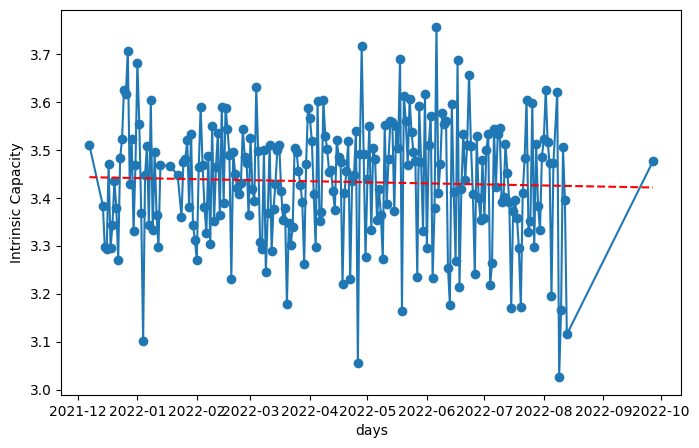

Stationary test for patient 1065442966 about Intrinsic Capacity data

ADF Statistic: -8.430340
p-value: 0.000000	 so the trend is stationary
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
KPSS Statistic: 0.101997
p-value: 0.100000	 so the trend is stationary
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


<ipython-input-53-a4f45cea2656>:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(X, regression = 'ct') # 'regression=ct --> null hypothesis is that the data is trend stationary


In [ ]:
plotPatientPerformanceScorePandas(dfTotPandas, '1065442966', 'Intrinsic Capacity')
adf_kpss_test_pandas(dfTotPandas, '1065442966', 'Intrinsic Capacity')

[3.5, 3.8582515037697354, 2.955223883336126, 2.915751819564248, 3.7407882500204654, 3.4958315662035413, 2.8128954226635488, 3.8588987966447386, 3.6671650970831786, 3.579875750339358, 3.7217556081334675, 3.9507018574654467, 3.53261586256528, 3.8627304311711557, 3.837025748033707, 3.463246602820944, 3.5774524363545774, 3.0817403214740544, 3.6860166496885327, 3.7287130398329054, 3.717890462737073, 3.5901307392170225, 3.003460092957804, 3.1034310948624104, 3.4585918834111546, 3.068497873857103, 3.2337505998851936, 3.141837983791651, 3.6911862701611056, 3.1218310841172126, 3.0313494116793605, 3.372600929500755, 3.5, 3.5, 3.5, 3.5, 3.5, 3.3636291355916192, 2.8241299809598557, 3.2583233152614257, 2.8151692434510243, 3.797922065253099, 2.8128954226635488, 3.5, 4.582538262212009, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 2.9793061604928397, 3.8073047560718587, 3.7882314660846275, 3.672669138790838, 3.4492505711763917, 3.621094434679007, 3.524067020004036, 3.70938211812594

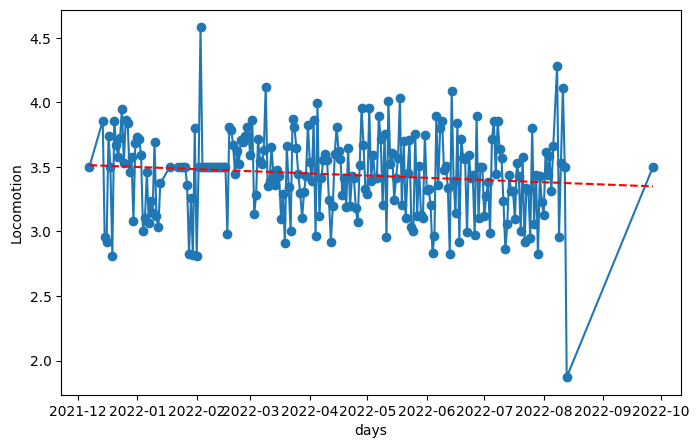

Stationary test for patient 1065442966 about Locomotion data

ADF Statistic: -15.949860
p-value: 0.000000	 so the trend is stationary
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
KPSS Statistic: 0.067123
p-value: 0.100000	 so the trend is stationary
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


<ipython-input-53-a4f45cea2656>:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(X, regression = 'ct') # 'regression=ct --> null hypothesis is that the data is trend stationary


In [ ]:
plotPatientPerformanceScorePandas(dfTotPandas, '1065442966', 'Locomotion')
adf_kpss_test_pandas(dfTotPandas, '1065442966', 'Locomotion')

[3.5481371368826173, 3.6053678232831583, 3.572291566164537, 3.552995477493747, 3.54720169173002, 3.5032083709208877, 3.564955655901553, 3.545233307534056, 3.549496277561137, 3.757037433144261, 3.8501597615399894, 4.0044236600343055, 3.8472443189042536, 4.105824872373734, 4.009304849591734, 3.9261730149147254, 3.9870346261210114, 4.075291349104789, 3.7181458196834636, 3.8468926458854646, 3.956688308159037, 3.765996128347253, 3.80846883613968, 3.8552893022841834, 3.4610541294054222, 3.748180990421502, 4.0390405420123425, 3.702979313980415, 3.7695365213887806, 4.126063977328389, 3.8288225997452976, 3.7766908102734824, 3.8526505682662133, 3.8854207239545686, 3.7345811647102454, 3.7318310447024645, 3.788873453728733, 3.7089953342929074, 3.6417902477853876, 3.684806296969893, 3.7514302699899478, 3.812562847129733, 3.718399508244136, 3.4923924267084137, 3.6925345263338505, 3.680412665086156, 3.5251121023407976, 3.702067625483811, 3.4800516394313754, 3.7679431335639406, 3.604911279061252, 3.77

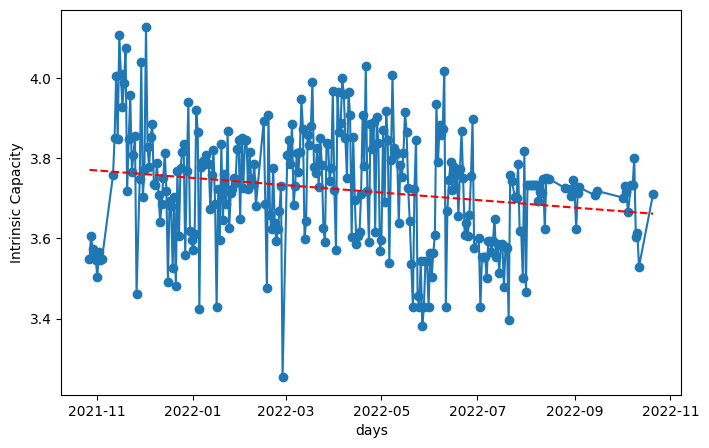

Stationary test for patient 303827011 about Intrinsic Capacity data

ADF Statistic: -5.597878
p-value: 0.000001	 so the trend is stationary
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
KPSS Statistic: 0.095504
p-value: 0.100000	 so the trend is stationary
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


<ipython-input-53-a4f45cea2656>:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(X, regression = 'ct') # 'regression=ct --> null hypothesis is that the data is trend stationary


In [ ]:
plotPatientPerformanceScorePandas(dfTotPandas, '303827011', 'Intrinsic Capacity')
adf_kpss_test_pandas(dfTotPandas, '303827011', 'Intrinsic Capacity')

[2.5665883877970326, 2.5855707287024234, 2.5665883877970326, 2.5665883877970326, 2.5665883877970326, 2.5665883877970326, 2.5665883877970326, 2.5665883877970326, 2.5715079104271066, 2.8517558648054107, 4.428611071015845, 4.510741522588145, 3.0649008835380203, 4.292574510610929, 3.735043593019502, 4.367710215162958, 3.6280296136844417, 4.184680382750627, 3.3101772576135406, 3.261349650453553, 3.465114673656137, 3.3949035798278224, 3.0572326140032793, 3.5424147412634053, 2.7044236523923075, 3.6888905581192715, 4.817551065293805, 3.3496908709763678, 3.453612802234519, 4.188927934334396, 3.4945806752703943, 3.752150284538971, 3.204469950197338, 3.987233838613081, 4.155636063217043, 3.650012430520584, 4.527973462206856, 4.330982258575157, 4.079415860375785, 4.151857765464337, 4.420535985753942, 4.522695105124951, 3.6501922587803115, 2.8843437879437626, 3.332705805234437, 3.490239037961161, 3.13713276045965, 4.003666728951183, 3.5245314629275457, 3.944989919879262, 3.943134977279306, 3.402617

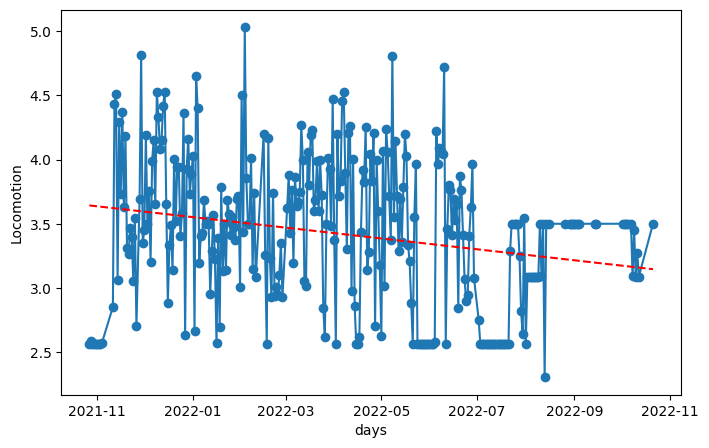

Stationary test for patient 303827011 about Locomotion data

ADF Statistic: -4.784846
p-value: 0.000058	 so the trend is stationary
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
KPSS Statistic: 0.116049
p-value: 0.100000	 so the trend is stationary
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


<ipython-input-53-a4f45cea2656>:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(X, regression = 'ct') # 'regression=ct --> null hypothesis is that the data is trend stationary


In [ ]:
plotPatientPerformanceScorePandas(dfTotPandas, '303827011', 'Locomotion')
adf_kpss_test_pandas(dfTotPandas, '303827011', 'Locomotion')

In [ ]:
#plotPatientPerformanceScore(dfTot, '1705741053', 'Locomotion')

In [ ]:
#plotPatientPerformanceScore(dfTot, '1705741053', 'Intrinsic Capacity')
#adf_kpss_test(dfTot, '1705741053', 'Intrinsic Capacity')

In [ ]:
#plotPatientPerformanceScore(dfTot, '1065442966', 'Intrinsic Capacity')
#adf_kpss_test(dfTot, '1065442966', 'Intrinsic Capacity')

In [ ]:
#dfTotPandas = dfTot.toPandas()
#plotPatientPerformanceScorePandas(dfTotPandas, '1065442966', 'Locomotion')
#plotPatientPerformanceScorePandas(dfTotPandas, '1065442966', 'Intrinsic Capacity')